# Hierarchical model for conditional reasoning
I want to create a simple hierarchical Bayesian model for predicting individual conditional human reasoning behavior.

The intuition is the following:

In the beginning, we do not anything about a single participant. Thus, we should not be able to make a much better guess at what she will do than using the empirical aggregate distribution as a forecast. Depending on the properness of the evaluation metric, we either use the most frequent answer or (parts of) the full empirical distribution.

This empirical distribution might be better if smoothened. This smoothening could be a feature of a cognitive theory, which superimposes an occamian prior on the observations.

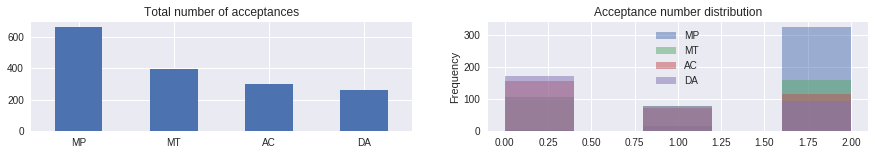

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scoring_rules

np.random.seed(42)

# Read in experimental data
patterns = pd.read_csv('../conditional_data/oberauer_81_patterns.csv')
patterns = patterns.drop(patterns.columns[0], axis=1)

# Transform counts into individual responses
data = []
for pattern in patterns.columns:
    frequency = patterns.loc[0, pattern]
    data += [[int(pattern[i]) for i in range(len(pattern))]] * frequency
data = pd.DataFrame(np.array(data), columns=['MP', 'MT', 'AC', 'DA'])

# Plot data summaries
fig, ax = plt.subplots(1, 2, figsize=(15,2))
data.sum(axis=0).plot(kind='bar', rot=0, ax=ax[0], title='Total number of acceptances')
data.plot(kind='hist', bins=5, alpha=0.5, ax=ax[1], title='Acceptance number distribution')
plt.show()

In [2]:
def one_hot(data):
    ''' 
    Transform data of form [1, 1, 1, 1] to one-hot-encoding form [0, 0, .... 1]
    '''
    indices = (data * np.array([8, 4, 2, 1])).sum(axis=1)
    one_hot_data = np.zeros((len(indices), 16))
    for i in range(len(indices)):
        one_hot_data[i, indices[i]] = 1
    return(one_hot_data)

In [3]:
# One participant said MP only
mp_only = one_hot(np.array([[1, 0, 0, 0]]))

# One participant said MP only, another MP and MT, another MP, MT, AC, DA
all_modes = one_hot(np.array([[1, 0, 0, 0], [1, 1, 0, 0], [1, 1, 1, 1]]))

# Subset of participants who gave consistent answers in both experiments
consistent = one_hot((data[data != 1].dropna().astype(int) // 2).values)

for truth, truth_name in [(mp_only, 'Truth = MP only'), 
                          (all_modes, 'Truth = {MP only, MP&MT, All Modi}'),
                          (consistent, 'Truth = Empirical Data')]:
    print(truth_name)
    print('Prediction\t Brier Logscore Accuracy MRR')
    
    # example predictions
    uniform_prediction = np.array([[1/16] * 16] * len(truth))
    all_only_prediction = np.array([[0] * 15 + [1]] * len(truth))
    empirical_distribution = np.array([consistent.mean(axis=0)]  * len(truth))
    mp_only_prediction = one_hot(np.array([[1, 0, 0, 0]] * len(truth)))


    for prediction, prediction_name in ((uniform_prediction, 'Uniform'),
                                        (all_only_prediction, 'Always ALL'),
                                        (mp_only_prediction, 'Always MP'),
                                        (empirical_distribution, 'Empirical')):
        print('{} \t {:1.2f} \t {:1.1f}  \t {:1.2f} \t {:1.2f}'.format(prediction_name,
                                                   scoring_rules.quad_score(prediction, truth), 
                                                   scoring_rules.mean_log_score(prediction, truth),                                                   
                                                   scoring_rules.mean_accuracy(prediction, truth),
                                                   scoring_rules.mrr_score(prediction, truth)))
    print()

Truth = MP only
Prediction	 Brier Logscore Accuracy MRR
Uniform 	 0.94 	 -2.8  	 0.06 	 0.06
Always ALL 	 2.00 	 -inf  	 0.00 	 0.06
Always MP 	 0.00 	 0.0  	 1.00 	 1.00
Empirical 	 0.71 	 -1.3  	 0.00 	 0.50

Truth = {MP only, MP&MT, All Modi}
Prediction	 Brier Logscore Accuracy MRR
Uniform 	 0.94 	 -2.8  	 0.06 	 0.06
Always ALL 	 1.33 	 -inf  	 0.33 	 0.38
Always MP 	 1.33 	 -inf  	 0.33 	 0.38
Empirical 	 0.68 	 -1.3  	 0.33 	 0.61

Truth = Empirical Data
Prediction	 Brier Logscore Accuracy MRR
Uniform 	 0.94 	 -2.8  	 0.06 	 0.06
Always ALL 	 1.36 	 -inf  	 0.32 	 0.36
Always MP 	 1.45 	 -inf  	 0.27 	 0.32
Empirical 	 0.75 	 -1.6  	 0.32 	 0.57

